In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from classifiers import KNN, LDA, RandomForest
import matplotlib.pyplot as plt
from plotter import seaborn_boxplot, seaborn_confusion
from misslabel import misslabel_data_simple, misslabel_data_specified
from helper import Evaluation, doubleCV, evaluate_best_models

KNN done tuning
LDA Done tuning
randomForest Done tuning


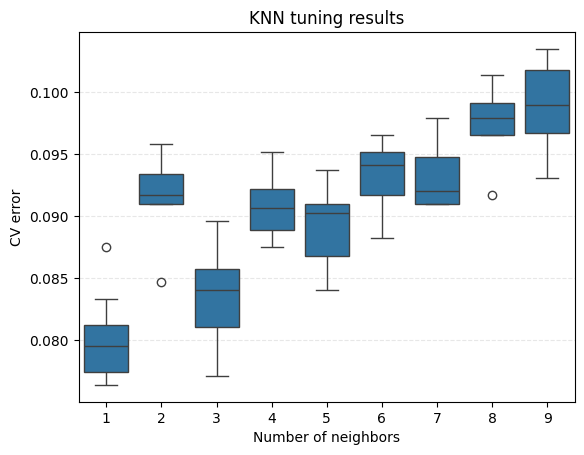

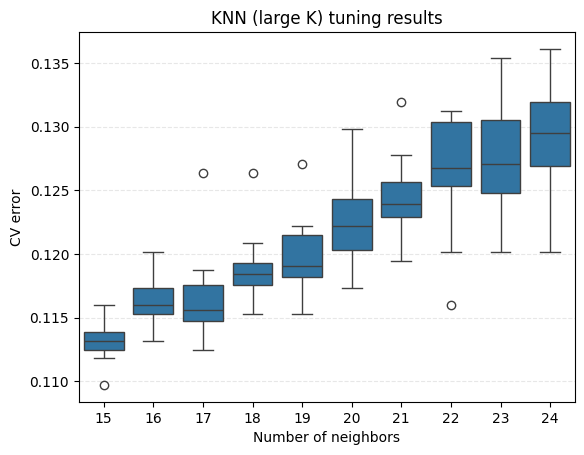

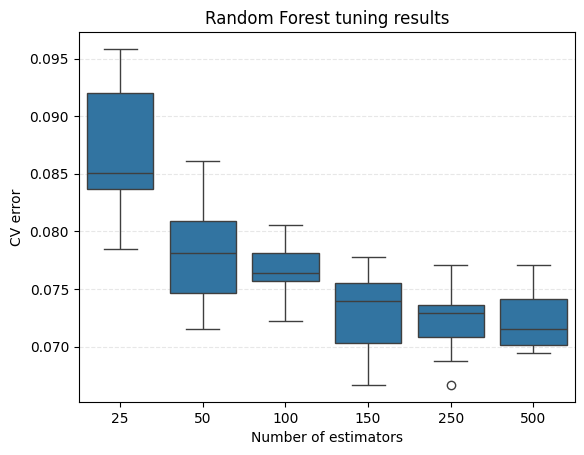

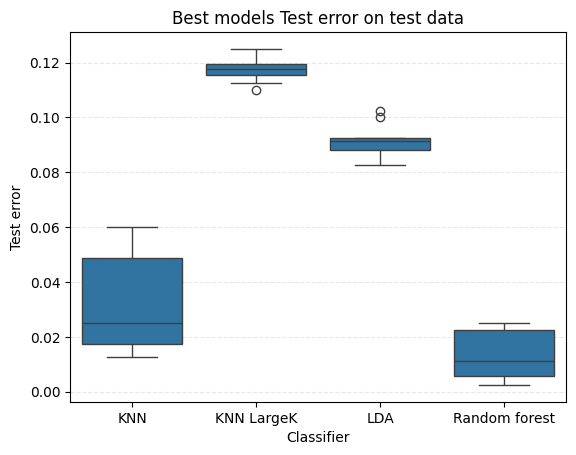

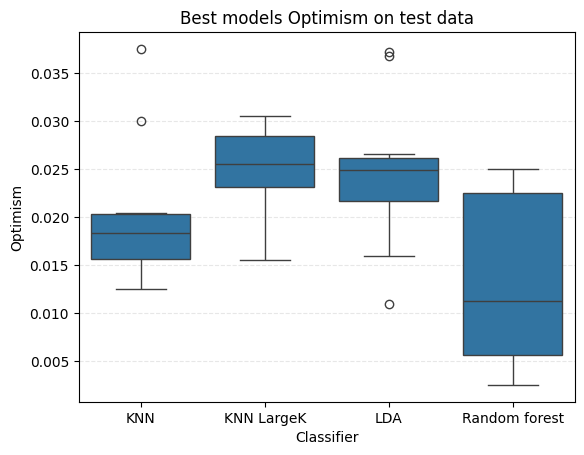

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


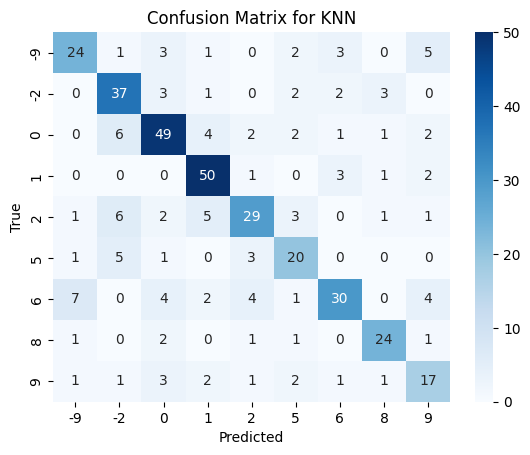

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


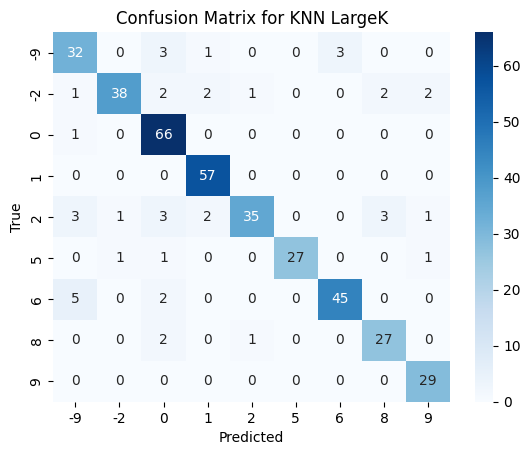

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


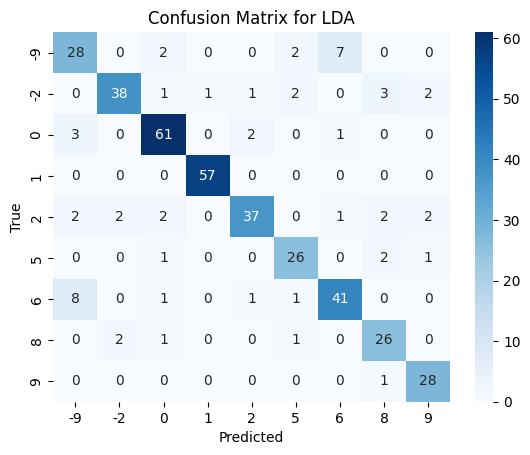

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


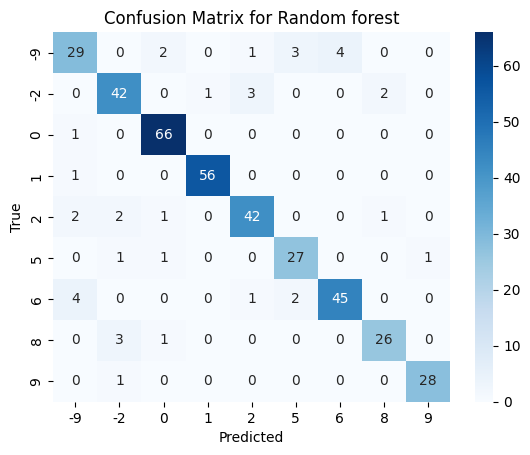

Final Test errors: {'KNN': 0.30000000000000004, 'KNN LargeK': 0.10999999999999999, 'LDA': 0.14500000000000002, 'Random forest': 0.09750000000000003}
Final Optimism: {'KNN': 0.26825000000000004, 'KNN LargeK': -0.007750000000000035, 'LDA': 0.053250000000000006, 'Random forest': 0.08375000000000005}


In [12]:


def main():
    # Load the data
    df = pd.read_csv('data/Numbers.txt', delimiter=' ')
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    classes = np.unique(y)
    labels = [str(i) for i in classes]

    # train test split
    X_t, X_tst, y_t, y_tst = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    X_tst = X_tst.to_numpy()
    y_tst = y_tst.to_numpy().reshape(-1,1)

    """Uncomment this to specify misslabeling or specified misslabeling"""
    y_t = misslabel_data_simple(y_t, 0.25)
    # y_t = misslabel_data_specified(y_t,6,[9,-9], 0.8, [0.5,0.5])

    outerCV = KFold(n_splits=10, shuffle=True, random_state=42)
    foldDataTraining = []
    foldDataTest = []
    #Plot data
    allTestErrors = {}
    optimism = {}
    df_best_models = {}
    finalTestErrors = {}
    finalOptimism = {}
    df_best_models = pd.DataFrame()

    #Get the folded training and test data
    for train_idx, test_idx in outerCV.split(X_t, y_t):
        X_train = X.iloc[train_idx].to_numpy()
        y_train = y.iloc[train_idx].to_numpy().reshape(-1, 1)

        X_test = X.iloc[test_idx].to_numpy()
        y_test = y.iloc[test_idx].to_numpy().reshape(-1, 1)

        train_combined = np.hstack((y_train, X_train))
        test_combined = np.hstack((y_test, X_test))

        foldDataTraining.append(train_combined)
        foldDataTest.append(test_combined)
    
    """Evaluation without tuning"""

    #KNN small k (flexible)
    kNNClassifier = KNN(n_neighbors=5)
    kNNtrainingErrorsNoTuning, kNNtestErrorsNoTuning = Evaluation(kNNClassifier,foldDataTraining,foldDataTest)
    allTestErrors["KNN (no tuning)"] = kNNtestErrorsNoTuning

    kNNOptimism = np.array(kNNtestErrorsNoTuning) - np.array(kNNtrainingErrorsNoTuning)
    optimism["KNN (no tuning)"] = kNNOptimism

    #KNN large k (rigid)
    kNNClassifierLarge = KNN(n_neighbors=20)
    kNNtrainingErrorsNoTuningLarge, kNNtestErrorsNoTuningLarge = Evaluation(kNNClassifierLarge,foldDataTraining,foldDataTest)
    allTestErrors["KNN LargeK (no tuning)"] = kNNtestErrorsNoTuningLarge
    
    kNNOptimismLarge = np.array(kNNtestErrorsNoTuningLarge) - np.array(kNNtrainingErrorsNoTuningLarge)
    optimism["KNN LargeK (no tuning)"] = kNNOptimismLarge
    
    #LDA 
    
    ldaClassifier = LDA() 
    ldaTrainingErrors, ldaTestErrors = Evaluation(ldaClassifier, foldDataTraining, foldDataTest)
    allTestErrors["LDA (no tuning)"] = ldaTestErrors

    LDAOptimism = np.array(ldaTestErrors) - np.array(ldaTrainingErrors)
    optimism["LDA (no tuning)"] = LDAOptimism

    #RandomForest
    rfClassifier = RandomForest()
    rfTrainingErrors, rfTestErrors = Evaluation(rfClassifier, foldDataTraining, foldDataTest)
    allTestErrors["Random Forest (no tuning)"] = rfTestErrors

    rfOptimism = np.array(rfTestErrors) - np.array(rfTrainingErrors)

    optimism["Random Forest (no tuning)"] = rfOptimism

    """Evaluation with tuning"""

    #KNN
    
    kNNparamGrid = {'n_neighbors': list(range(1,10))} #k = 1,2,...10 --> Flexible
    kNNparamGridLarge = {'n_neighbors': list(range(15,25))} #k = 15,16,...25 --> Rigid

    kNNtrainingErrors, kNNtestErrors, kNNBestModels, df_kNNTuningResults = doubleCV(foldDataTraining, foldDataTest, KNeighborsClassifier(), kNNparamGrid)
   

    df_kNNTuningResults["CV error"] = 1 - df_kNNTuningResults["mean_test_score"]
    df_kNNTuningResults = df_kNNTuningResults.rename(columns={"param_n_neighbors": "Number of neighbors"})
    df_kNNTuningResults.to_csv("data/kNNTuningResults_task1.csv")

    df_knn = evaluate_best_models(kNNBestModels, X_tst, y_tst)
    df_knn["Classifier"] = "KNN"
    df_knn["Optimism"] = df_knn["Test error"] - pd.Series(kNNtrainingErrors, index=df_knn.index)
    df_best_models = pd.concat([df_best_models, df_knn])
    
    kNNtrainingErrorsLarge, kNNtestErrorsLarge, kNNBestModelsLarge, df_kNNTuningResultsLarge = doubleCV(foldDataTraining, foldDataTest, KNeighborsClassifier(), kNNparamGridLarge)
    
    df_kNNTuningResultsLarge["CV error"] = 1 - df_kNNTuningResultsLarge["mean_test_score"]
    df_kNNTuningResultsLarge = df_kNNTuningResultsLarge.rename(columns={"param_n_neighbors": "Number of neighbors"})
    df_kNNTuningResultsLarge.to_csv("data/kNNTuningResults_task1_large.csv")

    df_knnlarge = evaluate_best_models(kNNBestModelsLarge, X_tst, y_tst)
    df_knnlarge["Classifier"] = "KNN LargeK"
    df_knnlarge["Optimism"] = df_knnlarge["Test error"] - pd.Series(kNNtrainingErrorsLarge, index=df_knnlarge.index)
    df_best_models = pd.concat([df_best_models, df_knnlarge])


    print("KNN done tuning")

    #LDA
    ldaParamGrid = [
    {'solver': ['svd']}, 
    {'solver': ['lsqr', 'eigen'], 'shrinkage': ['auto']},
    ]

    ldaTrainingErrors, ldaTestErrors, ldaBestModels, df_ldaTuningResults = doubleCV(foldDataTraining, foldDataTest, LinearDiscriminantAnalysis(), ldaParamGrid)
    
    df_ldaTuningResults["CV error"] = 1 - df_ldaTuningResults["mean_test_score"]
    df_ldaTuningResults = df_ldaTuningResults.rename(columns={"param_n_neighbors": "Number of neighbors"})
    df_ldaTuningResults.to_csv("data/ldaTuningResults_task1.csv")


    df_lda = evaluate_best_models(ldaBestModels, X_tst, y_tst)
    df_lda["Classifier"] = "LDA"
    df_lda["Optimism"] = df_lda["Test error"] - pd.Series(ldaTrainingErrors, index=df_lda.index)
    df_best_models = pd.concat([df_best_models, df_lda])

    print("LDA Done tuning")

    # #Random Forest
    rfParamGrid = {
    'n_estimators': [25, 50, 100, 150, 250, 500]          # number of trees
    }
    rfTrainingErrors, rfTestErrors, rfBestModels, df_rfTuningResults = doubleCV(foldDataTraining, foldDataTest, RandomForestClassifier(), rfParamGrid)
    
    df_rfTuningResults["CV error"] = 1 - df_rfTuningResults["mean_test_score"]
    df_rfTuningResults = df_rfTuningResults.rename(columns={"param_n_estimators": "Number of estimators"})
    df_rfTuningResults.to_csv("data/rfTuningResults_task1.csv")
    df_rf = evaluate_best_models(rfBestModels, X_tst, y_tst)
    df_rf["Classifier"] = "Random forest"
    df_rf["Optimism"] = df_rf["Test error"] - pd.Series(rfTrainingErrors, index=df_rf.index)
    df_best_models = pd.concat([df_best_models, df_rf])

    print("randomForest Done tuning")

    "Get plots"

    seaborn_boxplot(df_kNNTuningResults,"Number of neighbors","CV error", title="KNN tuning results") # Plot parameter performance for knn when tuning
    seaborn_boxplot(df_kNNTuningResultsLarge,"Number of neighbors","CV error", title="KNN (large K) tuning results") # Plot parameter performance for knn when tuning
    seaborn_boxplot(df_rfTuningResults,"Number of estimators","CV error", title="Random Forest tuning results") # Plot parameter performance for rf when tuning
    
    seaborn_boxplot(df_best_models,'Classifier','Test error',title="Best models Test error on test data")
    seaborn_boxplot(df_best_models,'Classifier','Optimism', title="Best models Optimism on test data")

    # Finds the parameter constilation that is most common among the best models from the tuning
    best_kNN_params = pd.Series([model.get_params() for model in kNNBestModels]).mode()[0]
    best_kNN_params_large = pd.Series([model.get_params() for model in kNNBestModelsLarge]).mode()[0]
    best_lda_params = pd.Series([model.get_params() for model in ldaBestModels]).mode()[0]
    best_rf_params = pd.Series([model.get_params() for model in rfBestModels]).mode()[0]

    optimalKNN = KNN(**{k: v for k, v in best_kNN_params.items() if k in ['n_neighbors', 'weights', 'algorithm', 'leaf_size', 'p', 'metric']})
    optimalKNNLarge = KNN(**{k: v for k, v in best_kNN_params_large.items() if k in ['n_neighbors', 'weights', 'algorithm', 'leaf_size', 'p', 'metric']})
    optimalLDA = LDA(**{k: v for k, v in best_lda_params.items() if k in ['solver', 'shrinkage', 'priors', 'n_components', 'store_covariance', 'tol']})
    optimalRF  = RandomForest(**{k: v for k, v in best_rf_params.items() if k in ['n_estimators', 'criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features','bootstrap','random_state']})

    optimal_models = {"KNN":optimalKNN, "KNN LargeK":optimalKNNLarge, "LDA":optimalLDA, "Random forest":optimalRF}
   
    # calculate the final test error for each model
    for name, model in optimal_models.items():
        model.fit(X_t,y_t)
        yPred = model.predict(X_tst)
        error = zero_one_loss(y_tst,yPred)
        finalTestErrors[name] = error
        finalOptimism[name] = error - df_best_models[df_best_models["Classifier"] == name]["Test error"].mean()

        cm = confusion_matrix(y_tst, yPred, labels=classes)
        seaborn_confusion(cm, labels, f"Confusion Matrix for {name}")
        
    
    print(f"Final Test errors: {finalTestErrors}\nFinal Optimism: {finalOptimism}")

main()